# World CO2 Emissions Forecasting
## LSTM Model
[*Cristian Castro Álvarez*](https://github.com/cristian-castro-a)

**Goal**: 
- Forecast the amount of World CO2 emissions (in tonnes) for the next 10 years (2021 - 2030).


**Data:**
- The data comes from [Our World in Data](https://github.com/owid/co2-data)
- Column 'CO2' of the dataframe indicates the Tonnes of CO2 emmitted into the atmosphere.
- The dataset includes yearly data from 1750 to 2020, with a total of 271 data points.

In [1]:
#Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings("ignore")

mpl.rcParams['figure.figsize'] = (15,10)
mpl.rcParams['axes.grid'] = False

# Data

In [2]:
df = pd.read_csv('../Data/owid-co2-data.csv')
df.head()

,iso_code,country,year,co2,co2_per_capita,trade_co2,cement_co2,cement_co2_per_capita,coal_co2,coal_co2_per_capita,...,ghg_excluding_lucf_per_capita,methane,methane_per_capita,nitrous_oxide,nitrous_oxide_per_capita,population,gdp,primary_energy_consumption,energy_per_capita,energy_per_gdp
0,AFG,Afghanistan,1949,0.015,0.002,NaN,NaN,NaN,0.015,0.002,...,NaN,NaN,NaN,NaN,NaN,7624058.0,NaN,NaN,NaN,NaN
1,AFG,Afghanistan,1950,0.084,0.011,NaN,NaN,NaN,0.021,0.003,...,NaN,NaN,NaN,NaN,NaN,7752117.0,9.421400e+09,NaN,NaN,NaN
2,AFG,Afghanistan,1951,0.092,0.012,NaN,NaN,NaN,0.026,0.003,...,NaN,NaN,NaN,NaN,NaN,7840151.0,9.692280e+09,NaN,NaN,NaN
3,AFG,Afghanistan,1952,0.092,0.012,NaN,NaN,NaN,0.032,0.004,...,NaN,NaN,NaN,NaN,NaN,7935996.0,1.001732e+10,NaN,NaN,NaN
4,AFG,Afghanistan,1953,0.106,0.013,NaN,NaN,NaN,0.038,0.005,...,NaN,NaN,NaN,NaN,NaN,8039684.0,1.063052e+10,NaN,NaN,NaN


In [3]:
# Aggregate the data on a yearly basis (the entire world as one entity, I don't care about the emissions of individual countries)
df = df.groupby(by=['year']).sum().reset_index()[['year','co2']]
df.insert(loc = 1, column = 'month', value = 12)
df.insert(loc = 2, column = 'day', value = 31)
values = pd.to_datetime(df[['year','month','day']])
df.insert(loc = 0, column = 'date', value = values)
df.drop(['year','month','day'], axis = 1, inplace = True)
df.head()

,date,co2
0,1750-12-31,46.755
1,1751-12-31,46.755
2,1752-12-31,46.770
3,1753-12-31,46.770
4,1754-12-31,46.790


In [4]:
# To work with tonnes of CO2 it is necessary a conversion factor of 3.664
df['co2'] = df['co2']/3.664
df.tail().round(1)

,date,co2
266,2016-12-31,34035.4
267,2017-12-31,34471.8
268,2018-12-31,35058.0
269,2019-12-31,35049.9
270,2020-12-31,33185.8


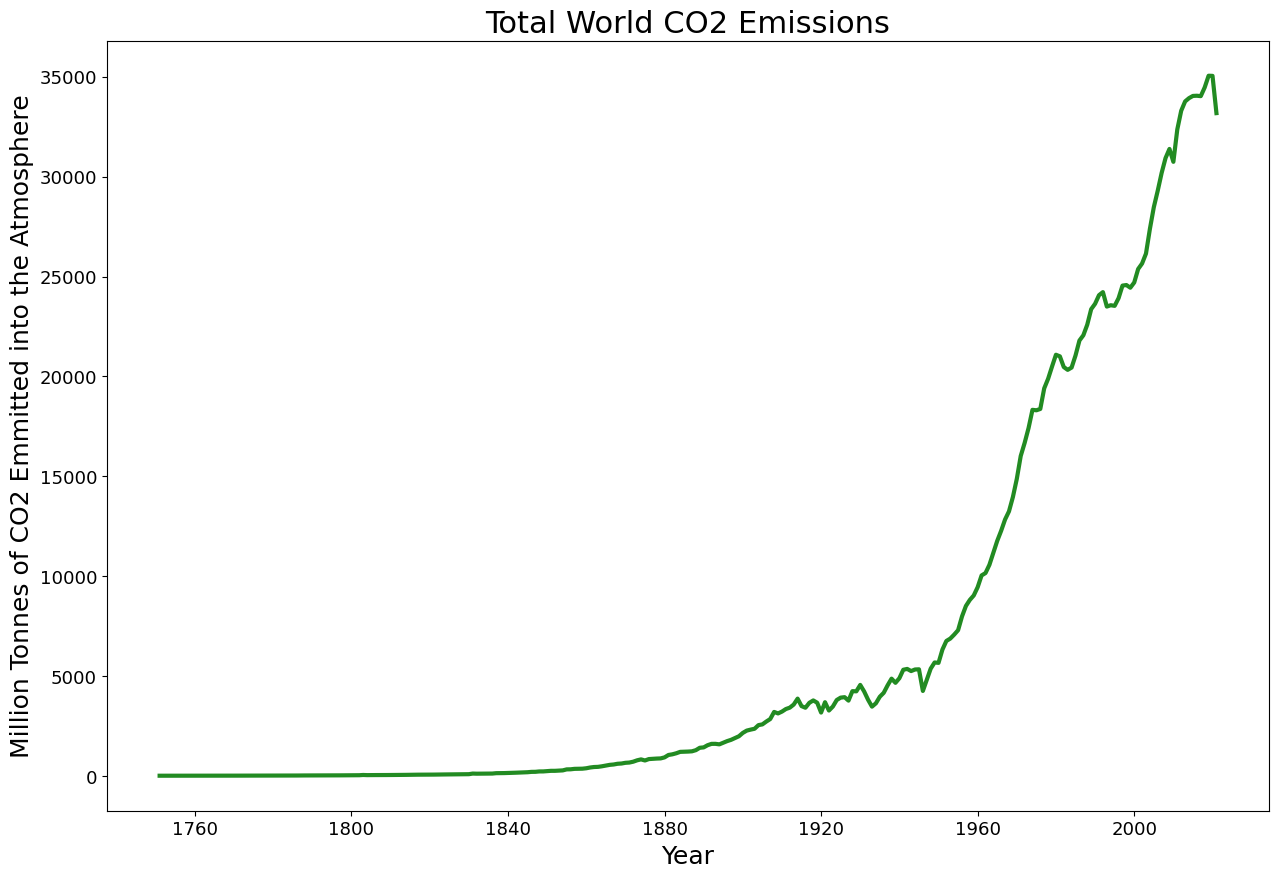

In [5]:
# Visualizing the yearly emission
plt.plot(df['date'],
         df['co2'],
         linewidth = 3,
         color = 'forestgreen')
plt.title('Total World CO2 Emissions', fontsize = 22)
plt.xlabel('Year', fontsize = 18)
plt.ylabel('Million Tonnes of CO2 Emmitted into the Atmosphere', fontsize = 18)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.show()

## Windowing

In [6]:
def df_to_inputs(df, window_size = 5):
    # Input: dataframe with the time series and window size
    # Windows size refers to the number of points in the series with which the model will be trained
    # Output: X, y for training
    df_as_np = df.to_numpy()
    X = []
    y = []
    
    for i in range(len(df_as_np)-window_size):
        X.append([[a] for a in df_as_np[i:i+5]])
        y.append(df_as_np[i+5])
    
    return np.array(X), np.array(y)

In [7]:
# Getting the windows
WINDOW_SIZE = 5
X, y = df_to_inputs(df['co2'], WINDOW_SIZE)

In [8]:
X.shape, y.shape

((266, 5, 1), (266,))

## Train, Validation and Test Sets

In [9]:
# 80% Train, 10% Valid, 10% Test
X_train, y_train = X[:213], y[:213]
X_val, y_val = X[213:240], y[213:240]
X_test, y_test = X[240:], y[240:]

In [10]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((213, 5, 1), (213,), (27, 5, 1), (27,), (26, 5, 1), (26,))

## Model

In [14]:
model = Sequential()
model.add(InputLayer((5,1)))
model.add(LSTM(64))
model.add(Dense(8, 'sigmoid'))
model.add(Dense(1, 'linear'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                16896     
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [15]:
cp = ModelCheckpoint('model', save_best_only = True)
model.compile(loss = MeanSquaredError(), optimizer = Adam(learning_rate=0.0001), metrics = [RootMeanSquaredError()])

In [16]:
model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 10, callbacks = [cp])

Train on 213 samples, validate on 27 samples
Epoch 1/10


2022-09-11 08:53:17.674006: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_standard_lstm_74073_74558_specialized_for_StatefulPartitionedCall_at___inference_distributed_function_74669' and '__inference___backward_cudnn_lstm_with_fallback_73767_73949' both implement 'lstm_ee85f934-8b2d-4bfb-aa61-9f8b4d003682' but their signatures do not match.


160/213 [=====================>........] - ETA: 0s - loss: 11627087.4000 - root_mean_squared_error: 3409.8516 

2022-09-11 08:53:18.924287: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_standard_lstm_74883_specialized_for_sequential_1_lstm_1_StatefulPartitionedCall_at___inference_distributed_function_75233' and '__inference_standard_lstm_74883' both implement 'lstm_9f205ec1-6c99-4bc9-8e5b-3696e4028934' but their signatures do not match.


INFO:tensorflow:Assets written to: model/assets
213/213 [==============================] - 5s 26ms/sample - loss: 12020661.7981 - root_mean_squared_error: 3467.0825 - val_loss: 423745536.0000 - val_root_mean_squared_error: 20585.0801
Epoch 2/10
213/213 [==============================] - 2s 11ms/sample - loss: 12020428.6103 - root_mean_squared_error: 3467.0488 - val_loss: 423744384.0000 - val_root_mean_squared_error: 20585.0527
Epoch 3/10
213/213 [==============================] - 3s 15ms/sample - loss: 12020058.3779 - root_mean_squared_error: 3466.9956 - val_loss: 423738240.0000 - val_root_mean_squared_error: 20584.9023
Epoch 4/10
213/213 [==============================] - 4s 18ms/sample - loss: 12019979.0563 - root_mean_squared_error: 3466.9841 - val_loss: 423737728.0000 - val_root_mean_squared_error: 20584.8906
Epoch 5/10
213/213 [==============================] - 3s 12ms/sample - loss: 12019930.1972 - root_mean_squared_error: 3466.9771 - val_loss: 423737312.0000 - val_root_mean_squa